In [129]:
import jax
import jax.numpy as jnp

jax.config.update("jax_platform_name", "cpu")
from jax.nn import relu
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad

In [2]:
def generate_all_genomes(n: int) -> jax.Array:
    assert n <= 8, "n must be less than or equal to 8"
    numbers = np.arange(0, 2**n).astype(np.uint8)
    bits = np.unpackbits(numbers[:, np.newaxis], axis=1)
    combinations = bits[:, -n:]
    return jnp.asarray(combinations)

# ReLU MLPs

In [143]:
def forward_fn(x, w1, b1, w2, b2, W3, b3, genome):
    """relu(relu(x @ W1 + b1) @ W2 + genome*b2) @ (genome[:, None]*W3) + b3"""
    t = x
    # shift x from [0, 1] to [-1, 1]
    x = x / 1 - 1
    x = jnp.dot(x, w1) + b1  # (B, num_features)
    x = relu(x)
    x = jnp.dot(x, w2) + genome * b2  # (B, genome_length)
    x = relu(x)
    x = jnp.dot(x, genome[:, None] * W3) + b3  # (B, 1)
    x = x * jnp.exp(-t / 2)  # Exponential decay
    return x

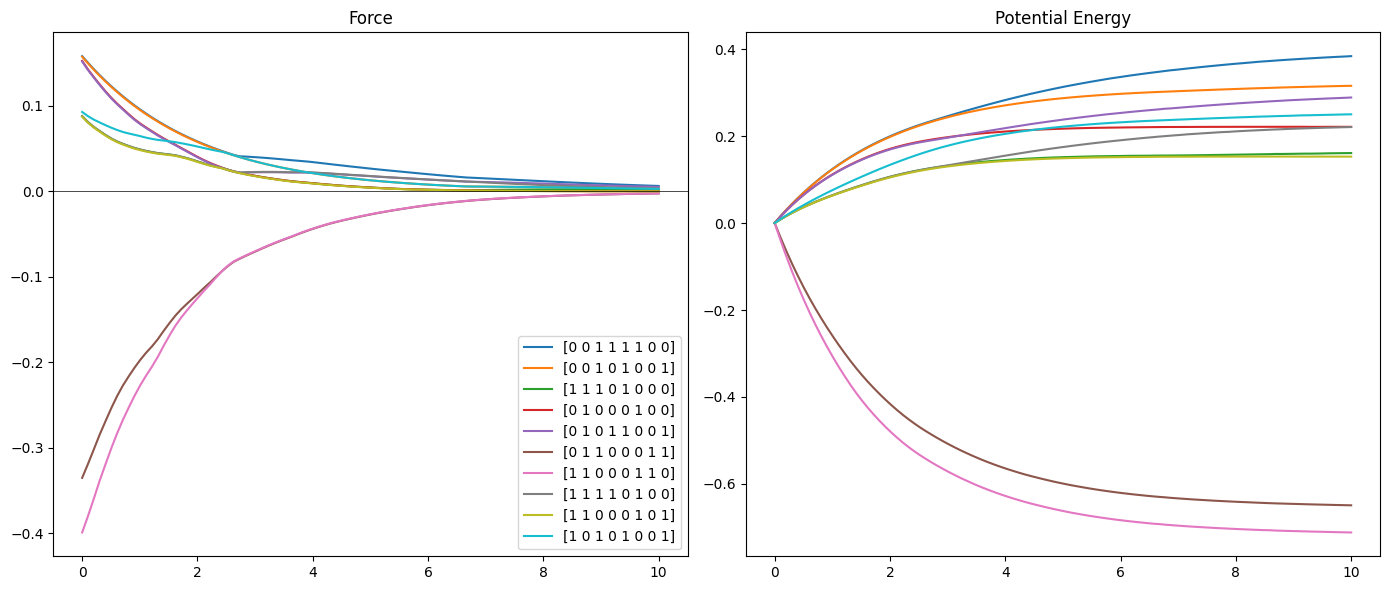

In [144]:
genome_length = 8
num_features = 128

key1w, key1b, key2w, key2b, key3w, key3b = jax.random.split(jax.random.PRNGKey(0), 6)
bias_init = 5e-1

W1 = jax.random.normal(key1w, (1, num_features)) / jnp.sqrt((1 + num_features) / 2)
b1 = jax.random.uniform(key1b, (num_features,), minval=-bias_init, maxval=bias_init)
W2 = jax.random.normal(key2w, (num_features, genome_length)) / jnp.sqrt((num_features + genome_length) / 2)
b2 = jax.random.uniform(key2b, (genome_length,), minval=-bias_init, maxval=bias_init)
W3 = jax.random.normal(key3w, (genome_length, 1)) / jnp.sqrt((genome_length + 1) / 2)
b3 = jax.random.uniform(key3b, (1,), minval=-bias_init, maxval=bias_init)
genomes = jax.random.choice(
    jax.random.PRNGKey(0), generate_all_genomes(genome_length), (min(10, 2**genome_length),), replace=False
)

# Force
x = jnp.linspace(0, 10, 100).reshape(-1, 1)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
for g in genomes:
    y = forward_fn(x, W1, b1, W2, b2, W3, b3, g)
    ax1.plot(x, y, label=str(g))
ax1.axhline(0, color="black", linewidth=0.5)
ax1.legend()
ax1.set_title("Force")


# Energy
for g in genomes:
    F_values = [
        quad(lambda t: forward_fn(t, W1, b1, W2, b2, W3, b3, g).item(), 0, x_i.squeeze(0), epsabs=1e-2)[0]
        for x_i in x
    ]
    ax2.plot(x, F_values, label=str(g))
ax2.set_title("Potential Energy")

plt.tight_layout()
plt.show()

# Polynomial Coefficients Modulation

In [145]:
def forward_fn(x, w, genome):
    coeffs = jnp.dot(w.T, genome)
    y = jnp.dot(jnp.stack([x**i for i in range(w.shape[-1])], axis=-1), coeffs) * jnp.exp(-1.3 * x)
    return y

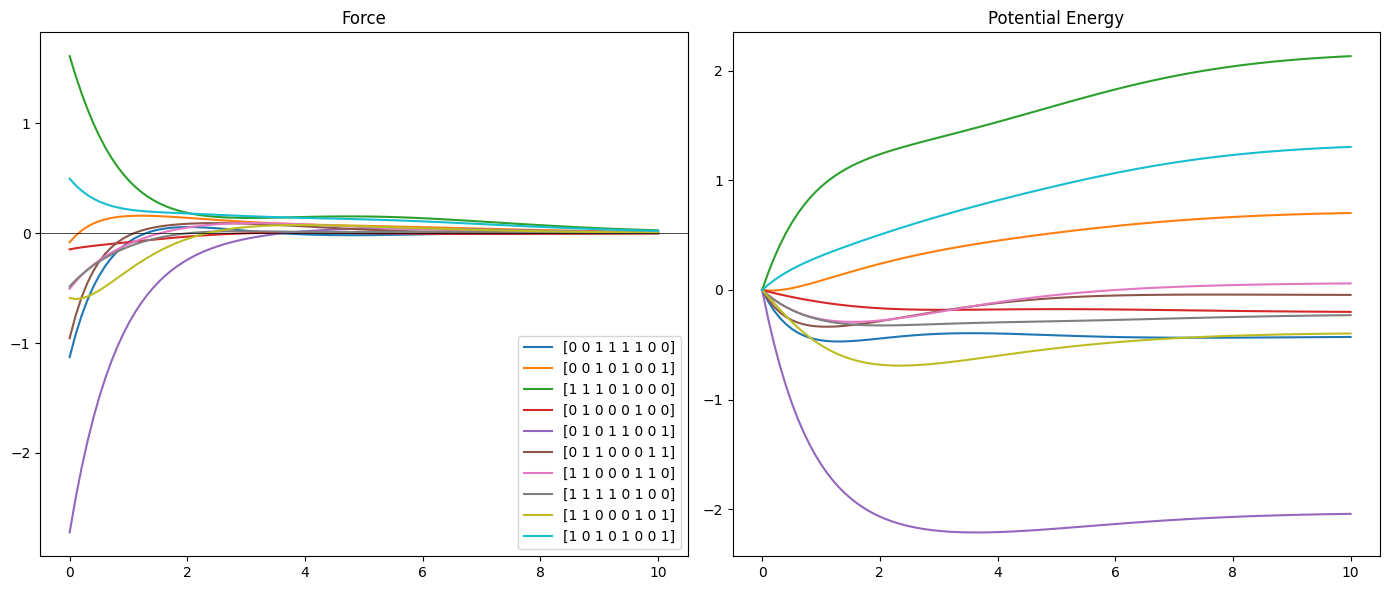

In [146]:
genome_length = 8
num_coefficients = 8

key1, key2 = jax.random.split(jax.random.PRNGKey(0))
scales = 1 / 10 ** (jnp.arange(num_coefficients) / 2)

W = scales[None, :] * jax.random.normal(key1, (genome_length, num_coefficients))
genomes = jax.random.choice(
    jax.random.PRNGKey(0), generate_all_genomes(genome_length), (min(10, 2**genome_length),), replace=False
)

# Force
x = jnp.linspace(0, 10, 100)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
for g in genomes:
    y = forward_fn(x, W, g)
    ax1.plot(x, y, label=str(g))
ax1.axhline(0, color="black", linewidth=0.5)
ax1.legend()
ax1.set_title("Force")

# Energy
for g in genomes:
    F_values = [quad(lambda t: forward_fn(t, W, g).item(), 0, x_i, epsabs=1e-2)[0] for x_i in x]
    ax2.plot(x, F_values, label=str(g))
ax2.set_title("Potential Energy")

plt.tight_layout()
plt.show()

# Fourier Basis

# RBF Kernel